# Road Network Simplification of Roundabouts
The following code exemplifies a simple process for road network simplification of roundabouts using [momepy.roundabout_simplification()](http://docs.momepy.org/en/latest/generated/momepy.roundabout_simplification.html?highlight=momepy.roundabout_simplification).

For this example we will fetch some data from [OpenStreetMap](https://www.openstreetmap.org/#map=6/40.007/-2.488) (using `osmnx`). However, most other data sources should also work as long as their topology has been corrected and can be sorted in a GeoDataFrame.
The underneath code uses only geometry operations to perform the simplification.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox

import momepy as mm

## Load data
Using `osmnx` download a neighborhood and reproject to its local CRS.

Two things are required to achieve good results:
1. Reproject the the network to a projected CRS (in meters, feet, etc..).
1. Transform the graph to an undirected graph:
    -  This helps to remove overlapping LineStrings once moving to GeoDataFrame.


In [2]:
place = "Chamberi, Madrid"

G = ox.graph_from_place(place, network_type="drive", simplify=True, buffer_dist=200)
G_projected = ox.project_graph(G)

edges = ox.graph_to_gdfs(
    ox.get_undirected(G_projected),  # prevents some (semi)duplicate geometries
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
)

edges.head(3)

osmid  oneway                      name  \
u        v          key                                                
21990706 21990729   0    390868364    True  Calle de Mejía Lequerica   
21990729 25906107   0    163743121    True  Calle de la Beneficencia   
         3144095503 0    390868364    True  Calle de Mejía Lequerica   

                             highway reversed  length  \
u        v          key                                 
21990706 21990729   0    residential    False  60.664   
21990729 25906107   0    residential    False  65.736   
         3144095503 0    residential    False   1.550   

                                                                  geometry  \
u        v          key                                                      
21990706 21990729   0    LINESTRING (440818.925 4475309.730, 440776.640...   
21990729 25906107   0    LINESTRING (440776.640 4475353.246, 440825.335...   
         3144095503 0    LINESTRING (440776.640 4475353.246, 440775.324...   

                             from          to maxspeed lanes bridge access  \
u        v          key                                                      
21990706 21990729   0    21990706    21990729      NaN   NaN    NaN    NaN   
21990729 25906107   0    21990729    25906107      NaN   NaN    NaN    NaN   
         3144095503 0    21990729  3144095503      NaN   NaN    NaN    NaN   

                        tunnel junction  
u        v          key                  
21990706 21990729   0      NaN      NaN  
21990729 25906107   0      NaN      NaN  
         3144095503 0      NaN      NaN

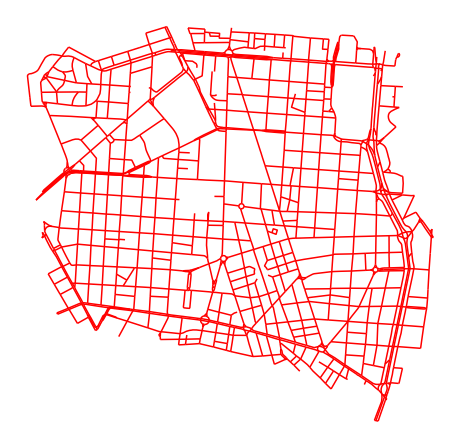

In [3]:
ax = edges.plot(figsize=(8, 12), color="red")
ax.set_axis_off()

## Playing with the different parameters
### _default_

In [4]:
edges_output = mm.roundabout_simplification(edges)

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


*_ShapelyDeprecationWarning should be resolved in further versions_.

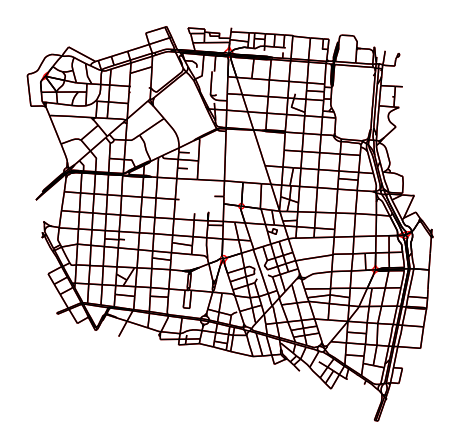

In [5]:
ax = edges.plot(figsize=(8, 12), color="red")
edges_output.plot(ax=ax, figsize=(8, 12), color="black")

ax.set_axis_off()

Using the output column _```simplification_group```_ we can count the number of roundabouts that were simplified.

In [6]:
edges_output.simplification_group.nunique()

7

In total **7** roundabouts were simplified, and most of their incoming edges were also considered during the process. 

Let's look at them individually.

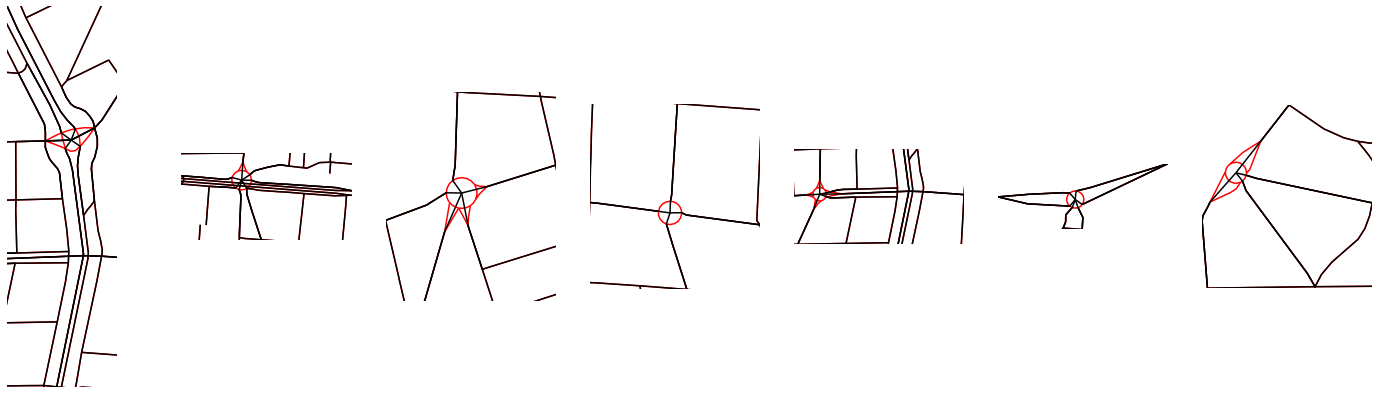

In [7]:
simplification_groups = edges_output.simplification_group.unique()[1:]

fig, axs = plt.subplots(1, len(simplification_groups), figsize=(25, 7))
axs = axs.flatten()

for i in simplification_groups:
    mask = edges_output.simplification_group == i
    minx, miny, maxx, maxy = edges_output[mask].geometry.total_bounds

    edges.plot(ax=axs[i], color="red")
    edges_output.plot(ax=axs[i], color="black")

    axs[i].set_xlim(minx, maxx)
    axs[i].set_ylim(miny, maxy)
    axs[i].set_axis_off()

plt.show()

It's worth investigating why some roundabouts are still missing from simplification.
Since the selection of roundabouts is based on the resulting polygons after polygonizing the road network let's use the [Circular Compactness](https://docs.momepy.org/en/stable/generated/momepy.CircularCompactness.html) parameter of the resulting polygons as the main selection attribute.

In [8]:
from shapely.ops import polygonize

polys = gpd.GeoDataFrame(
    geometry=[g for g in polygonize(edges.geometry)], crs=edges.crs
)
circom_serie = mm.CircularCompactness(polys).series
polys.loc[:, "circom"] = circom_serie

The _```circom_threshold```_ parameter (default = 0.7) establishes the limit at which roundabouts should be selected.

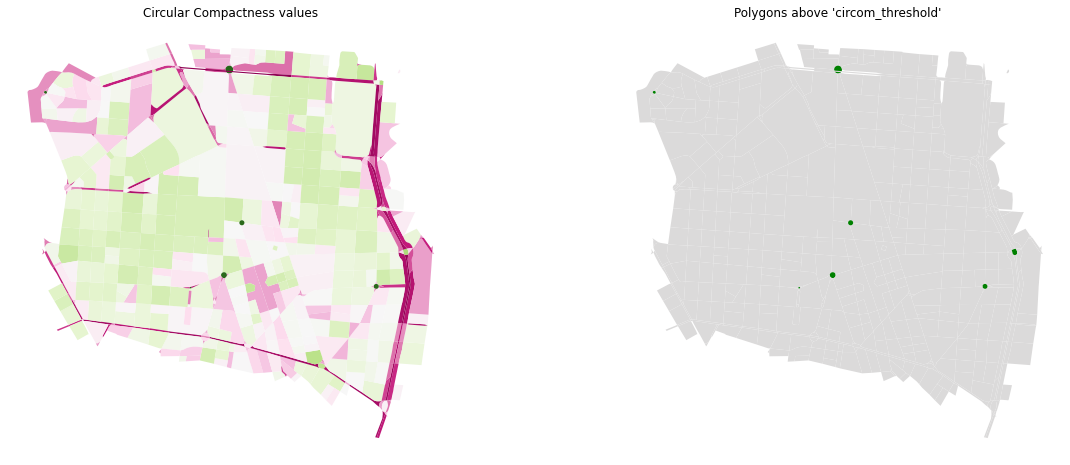

In [9]:
circom_threshold = 0.7
mask = circom_serie > circom_threshold
colors = ["green" if m == True else "#dbdada" for m in mask]

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

polys.plot(ax=axs[0], column="circom", cmap="PiYG")
axs[0].set_axis_off()
axs[0].title.set_text("Circular Compactness values")

polys.plot(ax=axs[1], color=colors)
axs[1].set_axis_off()
axs[1].title.set_text("Polygons above 'circom_threshold' ")

Let's see the following two **false negatives**,

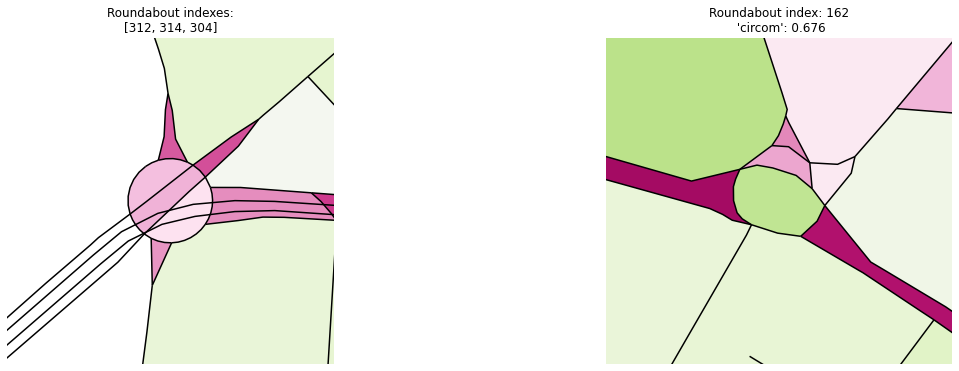

In [10]:

false_negatives = [[312,314,304], 162]


fig, axs = plt.subplots(1, 2, figsize=(20, 6))


edges.plot(ax= axs[0], color= "black")
polys.plot(ax= axs[0], column="circom", cmap="PiYG")
minx, miny, maxx, maxy = polys.loc[false_negatives[0]].geometry.total_bounds
axs[0].set_xlim(minx-75, maxx+75)
axs[0].set_ylim(miny-75, maxy+75)
axs[0].set_axis_off()
axs[0].title.set_text("Roundabout indexes:\n" + str(false_negatives[0]))

edges.plot(ax= axs[1], color= "black")
polys.plot(ax= axs[1], column="circom", cmap="PiYG")
minx, miny, maxx, maxy = polys.loc[false_negatives[1]].geometry.bounds
label_str = str(round(polys.loc[false_negatives[1]].circom,3))

axs[1].set_xlim(minx-75, maxx+75)
axs[1].set_ylim(miny-75, maxy+75)
axs[1].set_axis_off()
axs[1].title.set_text("Roundabout index: 162\n 'circom': "+ label_str)


The above helps to exemplify two main reasons why some roundabouts are not being selected:
1. They are crossed by other roads; which breaks them into multiple polygons.
    - eg. `index`: ```[314, 312, 304]```
1. They don't meet the `circom_threshold`.
     - eg. `index`: ```[162]``` --> (0.676) 
     
## Lowering _**circom_threshold**_ & _**include_adjacent**_ = False
Finally, let's also explore what the outcome would look like if we lower the `circom_threshold` and `include_adjacent` is set to `False`.

In [11]:
edges_output_65 = mm.roundabout_simplification(
    edges, circom_threshold=0.65, include_adjacent=False
)

m = edges.explore(color = "black", tiles = "CartoDB positron")
edges_output.explore(m=m, color="red")
edges_output_65.explore(m=m, color="blue")
m

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [12]:
edges_output_65.simplification_group.nunique()

13

Even though we have been able to simplify **13** supposedly polygons, this sample now contains some false positives. So it is up to the user to decide the right balance to make the most of this simplification. 

Note that this is a work in progress and some upcoming enhancements are expected to complement this simplification.